In [40]:
# Author: James Meehan
# Date: 8/15/2018
# Description: Machine learning model to Predict Week 1 2018 fantasy scores for quarterbacks

# import libraries
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
from sklearn import preprocessing

In [41]:
# pull in data, separate into data stack, labels, and actual scores
df = pd.read_csv('QBstack2018.csv', sep=',')
pts_targets = df
labels = df
labels = labels.loc[0:, 'fname':'actual']
labels = labels.values

df = df.loc[0:, 'rating':'rutd_2wk']
pts_targets = pts_targets.loc[0:, 'actual']

df = df.values

df = df[:-1]
pts_targets = pts_targets[:-1]
labels = labels[:-1]
df.shape


(1326, 26)

In [42]:
# normalize the inputs
scaled_inputs = preprocessing.scale(df)
print(scaled_inputs)

samples_count = scaled_inputs.shape[0]

# split into test and training groups
train_samples = int(0.8*samples_count)
test_samples = int(samples_count - train_samples)

train_inputs = scaled_inputs[:train_samples]
train_targets = pts_targets[:train_samples]

test_inputs = scaled_inputs[train_samples:]
test_targets = pts_targets[train_samples:]
test_targets.shape

[[ 0.43938014  1.02288626  0.15011665 ... -0.84118752 -0.56755166
  -0.3574535 ]
 [-0.91838744  1.02288626  1.70619967 ...  0.27955064 -0.6251515
  -0.3574535 ]
 [-1.73304799 -0.9776258   0.06329428 ... -0.84118752 -0.797951
  -0.3574535 ]
 ...
 [ 2.47603152  1.02288626  0.47526833 ...  0.27955064 -0.2795525
  -0.3574535 ]
 [ 1.66137097 -0.9776258   0.33591761 ... -0.84118752 -0.797951
  -0.3574535 ]
 [ 1.11826394  1.02288626  0.19656689 ...  0.27955064 -0.9707505
  -0.3574535 ]]


(266,)

In [43]:
print("Training set: {}".format(train_inputs.shape))  # 1060 examples, 26 features
print("Testing set:  {}".format(test_inputs.shape))   # 266 examples, 26 features

Training set: (1060, 26)
Testing set:  (266, 26)


In [45]:
# build the neural network.  1 hidden layer and 40 neurons.
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(40, activation=tf.nn.relu, 
                       input_shape=(train_inputs.shape[1],)),
    keras.layers.Dense(1)
  ])
  #AdamOptimizer
  optimizer = tf.train.AdamOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 40)                1080      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [46]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

# Store training stats
history = model.fit(train_inputs, train_targets, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


..................................................

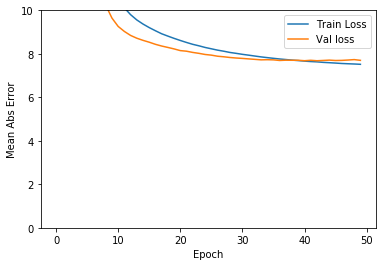

In [47]:
#Graph Training
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,10])

plot_history(history)

In [75]:
# calculate predictions
[loss, mae] = model.evaluate(test_inputs[:-11], test_targets[:-11], verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae))
print("Testing set Mean Squared Error: {:7.2f}".format(loss))

Testing set Mean Abs Error:    7.60
Testing set Mean Squared Error:   94.98


In [76]:
# get predictions
test_predictions = model.predict(test_inputs).flatten()


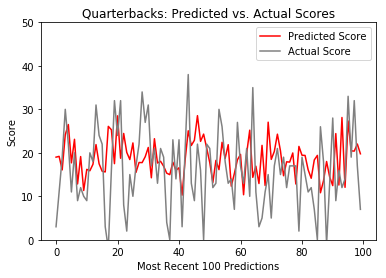

In [78]:
# graph predicted vs. actual scores
def plot_predict():
  plt.figure()
  plt.title('Quarterbacks: Predicted vs. Actual Scores')
  plt.xlabel('Most Recent 100 Predictions')
  plt.ylabel('Score')
  plt.plot(np.array(test_predictions[153:253]), label = "Predicted Score", color="red")
  plt.plot(np.array(test_targets[153:253]), label = "Actual Score", color="grey")
  plt.legend()
  plt.ylim([0,50])

plot_predict()

In [80]:
# get Week 1 2018 predictions
predict2018 = test_predictions[-11:]
QBtest_labels = labels[-11:]

fullList = []

for i in range(0, len(predict2018)):
    mylist = []
    mylist.append(QBtest_labels[i][0])
    mylist.append(QBtest_labels[i][1])
    mylist.append(int(QBtest_labels[i][2]))
    mylist.append(int(QBtest_labels[i][3]))
    mylist.append(0)
    mylist.append(predict2018[i])
    fullList.append(mylist)
print (fullList)

[['Tom', 'Brady', 1, 2018, 0, 18.51752], ['Aaron ', 'Rodgers', 1, 2018, 0, 18.309494], ['Cam ', 'Newton', 1, 2018, 0, 25.125414], ['Carson', 'Wentz', 1, 2018, 0, 17.025003], ['Russell ', 'Wilson', 1, 2018, 0, 21.944914], ['Alex', 'Smith', 1, 2018, 0, 13.390667], ['DeShaun', 'Watson', 1, 2018, 0, 10.981978], ['Matthew', 'Stafford', 1, 2018, 0, 24.195944], ['Kirk', 'Cousins', 1, 2018, 0, 23.909292], ['Ben ', 'Roethlisberger', 1, 2018, 0, 20.033718], ['Drew', 'Brees', 1, 2018, 0, 24.211864]]


In [87]:
# put predictions into csv for easy placement into database
import csv
from pandas import read_csv 

with open("QB2018Output.csv","w",newline="") as newFile: 
    cw = csv.writer(newFile, delimiter=',')
    for i in fullList:
        cw.writerow(i)
        
QBformat = read_csv('QB2018Output.csv', sep=',', names=['fname', 'lname', 'week', 'yr', 'actual', 'predicted'])
QBformat.to_csv('QB2018Output.csv', index=False)

In [88]:
# set up database connection
import psycopg2
conn = psycopg2.connect(database="Cepheus_db",
                        user="db_usr",
                        password="B3av3rs1!",
                        host="osucepheus.cgwruhobay1w.us-east-2.rds.amazonaws.com",
                        port="5432")

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [89]:
# put training predict data into database
#Create cursor with which to execute queries
cur = conn.cursor()

#parse csv
with open ('QB2018Output.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        #build query string
        query1 = 'INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES '
        query2 =row['fname'], row['lname'], row['week'], row['yr'], row['actual'], row['predicted']
        query = str(query1) + str(query2)
        print(query)
        #execute query
        cur.execute(query)
#commit change
conn.commit()

INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Tom', 'Brady', '1', '2018', '0', '18.51752')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Aaron ', 'Rodgers', '1', '2018', '0', '18.309494')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Cam ', 'Newton', '1', '2018', '0', '25.125414000000003')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Carson', 'Wentz', '1', '2018', '0', '17.025002999999998')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Russell ', 'Wilson', '1', '2018', '0', '21.944914')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Alex', 'Smith', '1', '2018', '0', '13.390667')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('DeShaun', 'Watson', '1', '2018', '0', '10.981978')
INSERT INTO qb_results(fname, lname, week, yr, actual, predicted) VALUES ('Matthew', 'Stafford', '1', '2018', '0',